### Exercício 01

![alt text](ex1.png)

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig

# Classe que representa a cadeia atômica
class CadeiaAtomica:
    def __init__(self, N: int, tipo: str = 'homogenea', k: float = 1.0):
        self.N = N               # Número de átomos na cadeia
        self.k = k               # Constante elástica das molas
        self.tipo = tipo.lower()  # Tipo da cadeia ('homogenea' ou 'ternaria')
        self.massas = self._gerar_massas()  # Vetor com as massas dos átomos

    def _gerar_massas(self):
        m = 1.0  # Massa base
        if self.tipo == 'homogenea':
            return np.full(self.N, m)
        elif self.tipo == 'ternaria':
            # Alternância m, 3m, 5m, m, 3m, 5m, ...
            pattern = [m, 3*m, 5*m]
            return np.array([pattern[i % 3] for i in range(self.N)])

    def montar_matrizes(self):
        # Matriz de massa (diagonal)
        M = np.diag(self.massas)
        K = np.zeros((self.N, self.N))

        # Matriz de rigidez K com condições de contorno com pontas livres (as extremidades da cadeia não estão presas).
        for i in range(self.N):
            if i > 0:
                K[i, i - 1] = -self.k
            if i < self.N - 1:
                K[i, i + 1] = -self.k
            K[i, i] = (K[i] != 0).sum() * self.k

        return M, K

    def calcular_frequencias_e_modos(self):
        M, K = self.montar_matrizes()

        matrix = K@M

        # achar autovalores e autovetores
        eigvals, eigvecs = eig(matrix)

        # Remove valores negativos e ordena
        # eigvals = np.clip(eigvals, 0, None)
        # freq = np.sqrt(eigvals)
        freq = eigvals

        return freq, eigvecs

    def plotar_frequencias(self, freq):
        plt.figure(figsize=(8, 4))
        plt.plot(freq, '.', markersize=4)
        plt.title(f"Frequências Naturais - {self.tipo.capitalize()} (N={self.N})")
        plt.xlabel("Modo")
        plt.ylabel("Frequência (rad/s)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plotar_modos_normais(self, modos, freq, n_modos=3):
        plt.figure(figsize=(10, 6))
        for i in range(n_modos):
            desloc = modos[:, i]
            desloc /= np.max(np.abs(desloc))  # Normaliza o deslocamento
            plt.subplot(n_modos, 1, i + 1)
            plt.plot(desloc, marker='o')
            plt.title(f"Modo {i + 1} - Freq: {freq[i]:.4f} rad/s")
            plt.xlabel("Índice do Átomo")
            plt.ylabel("Deslocamento")
            plt.grid(True)
        plt.tight_layout()
        plt.show()


In [48]:
Ns = [100, 1000]
tipos = ['homogenea', 'ternaria']

for N in Ns:
    for tipo in tipos:
        print(f"\n===== N = {N}, Tipo = {tipo} =====")
        sistema = CadeiaAtomica(N=N, tipo=tipo, k=1.0)
        freq, modos = sistema.calcular_frequencias_e_modos()
        print("Primeiras 5 frequências:", freq[:100])


===== N = 100, Tipo = homogenea =====


C:\Users\g.reisch\AppData\Local\Temp\ipykernel_11680\1170588840.py:40: RuntimeWarning: divide by zero encountered in divide
  matrix = K/M
C:\Users\g.reisch\AppData\Local\Temp\ipykernel_11680\1170588840.py:40: RuntimeWarning: invalid value encountered in divide
  matrix = K/M


ValueError: array must not contain infs or NaNs

### Exercício 02
![alt text](ex2.png)


--- Comparando densidade de estados para N = 100 ---


c:\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:7004: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16
c:\anaconda3\Lib\site-packages\matplotlib\transforms.py:2872: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


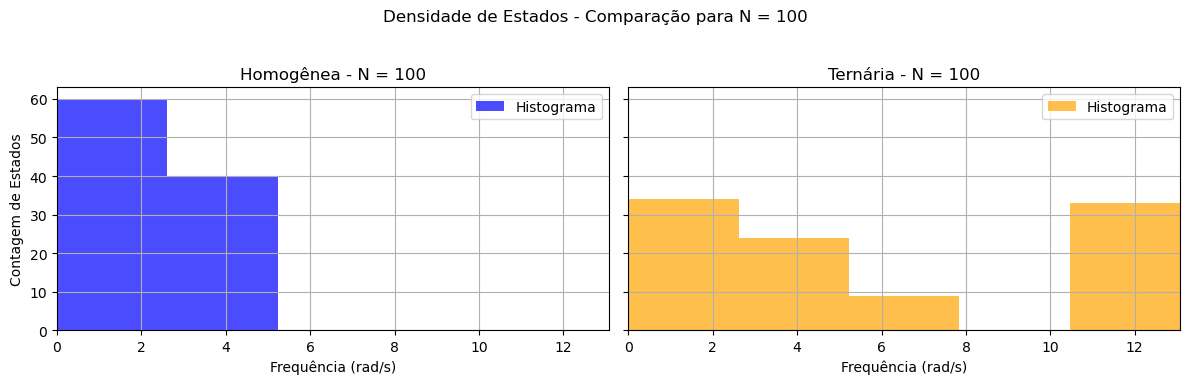


--- Comparando densidade de estados para N = 1000 ---


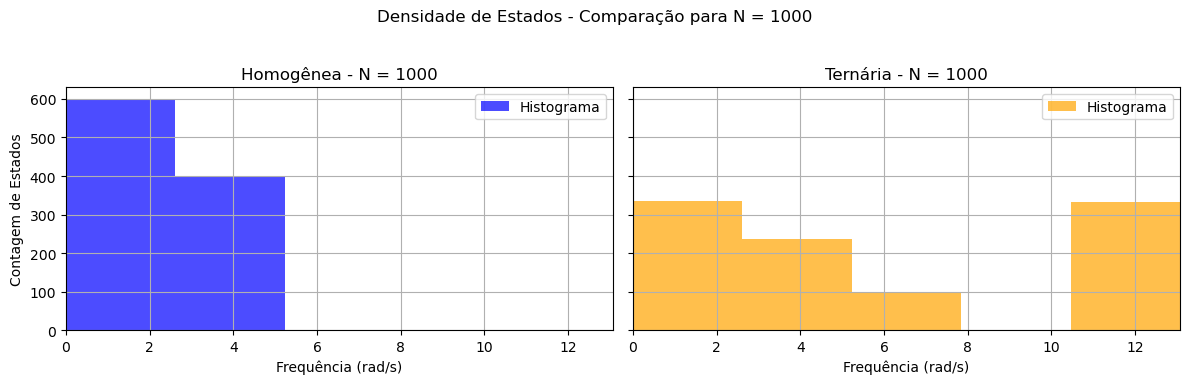

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def plotar_densidade_de_estados(freq_hom, freq_tern, N, bins=5):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # Determinar os limites do histograma
    freq_min = min(np.min(freq_hom), np.min(freq_tern))
    freq_max = max(np.max(freq_hom), np.max(freq_tern))
    bin_edges = np.linspace(freq_min, freq_max, bins + 1)  # Define os intervalos dos bins

    # Homogênea
    axs[0].hist(freq_hom, bins=bin_edges, color='blue', alpha=0.7, label='Histograma')
    axs[0].set_xlim(freq_min, freq_max)
    axs[0].set_title(f"Homogênea - N = {N}")
    axs[0].set_xlabel("Frequência (rad/s)")
    axs[0].set_ylabel("Contagem de Estados")
    axs[0].grid(True)

    # Ternária
    axs[1].hist(freq_tern, bins=bin_edges, color='orange', alpha=0.7, label='Histograma')
    axs[1].set_xlim(freq_min, freq_max)
    axs[1].set_title(f"Ternária - N = {N}")
    axs[1].set_xlabel("Frequência (rad/s)")
    axs[1].grid(True)

    # Adiciona legendas
    axs[0].legend()
    axs[1].legend()

    plt.suptitle(f"Densidade de Estados - Comparação para N = {N}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Laço principal para gerar os histogramas para N = 100, 1000
Ns = [100, 1000]
for N in Ns:
    print(f"\n--- Comparando densidade de estados para N = {N} ---")
    sistema_hom = CadeiaAtomica(N=N, tipo='homogenea')
    freq_hom, _ = sistema_hom.calcular_frequencias_e_modos()

    sistema_tern = CadeiaAtomica(N=N, tipo='ternaria')
    freq_tern, _ = sistema_tern.calcular_frequencias_e_modos()

    plotar_densidade_de_estados(freq_hom, freq_tern, N)


### Exercício 03
![alt text](ex3.png)


===== N = 100 =====


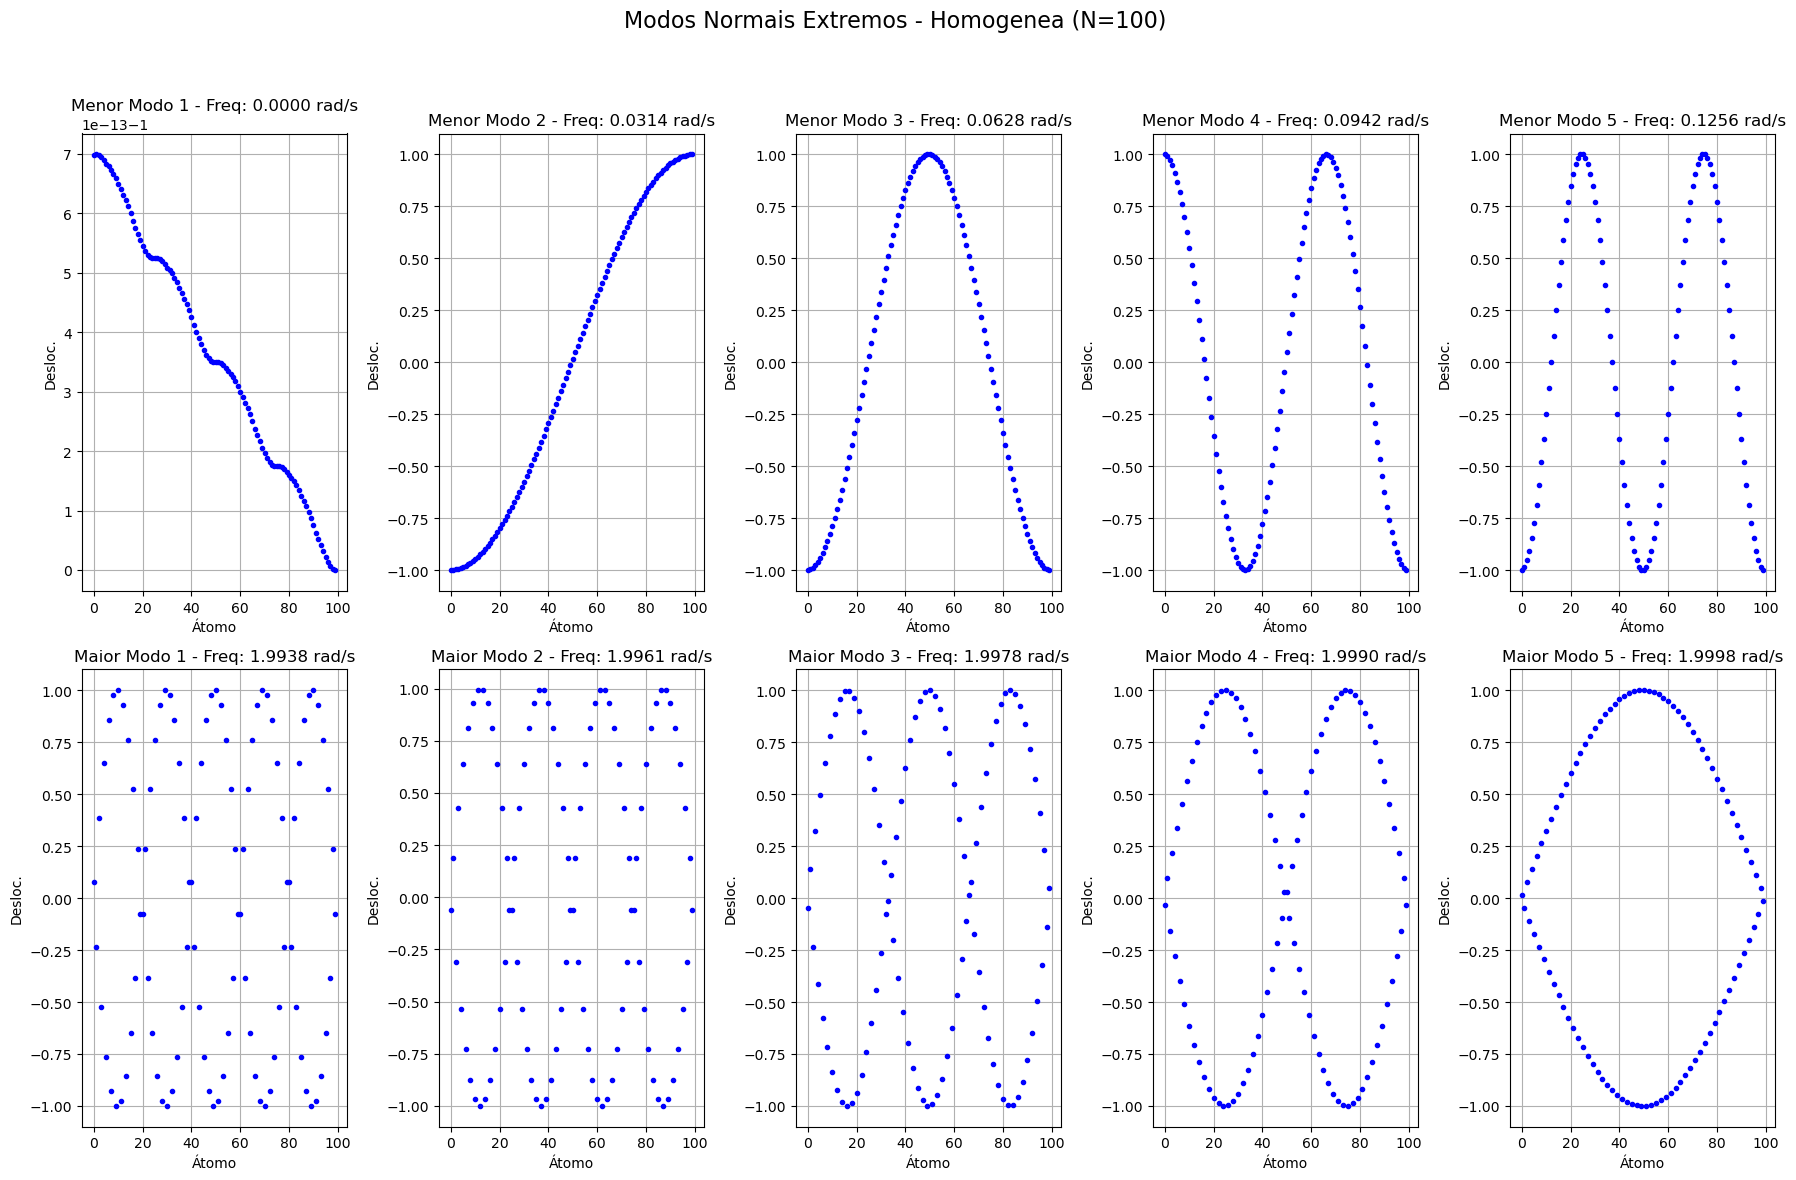

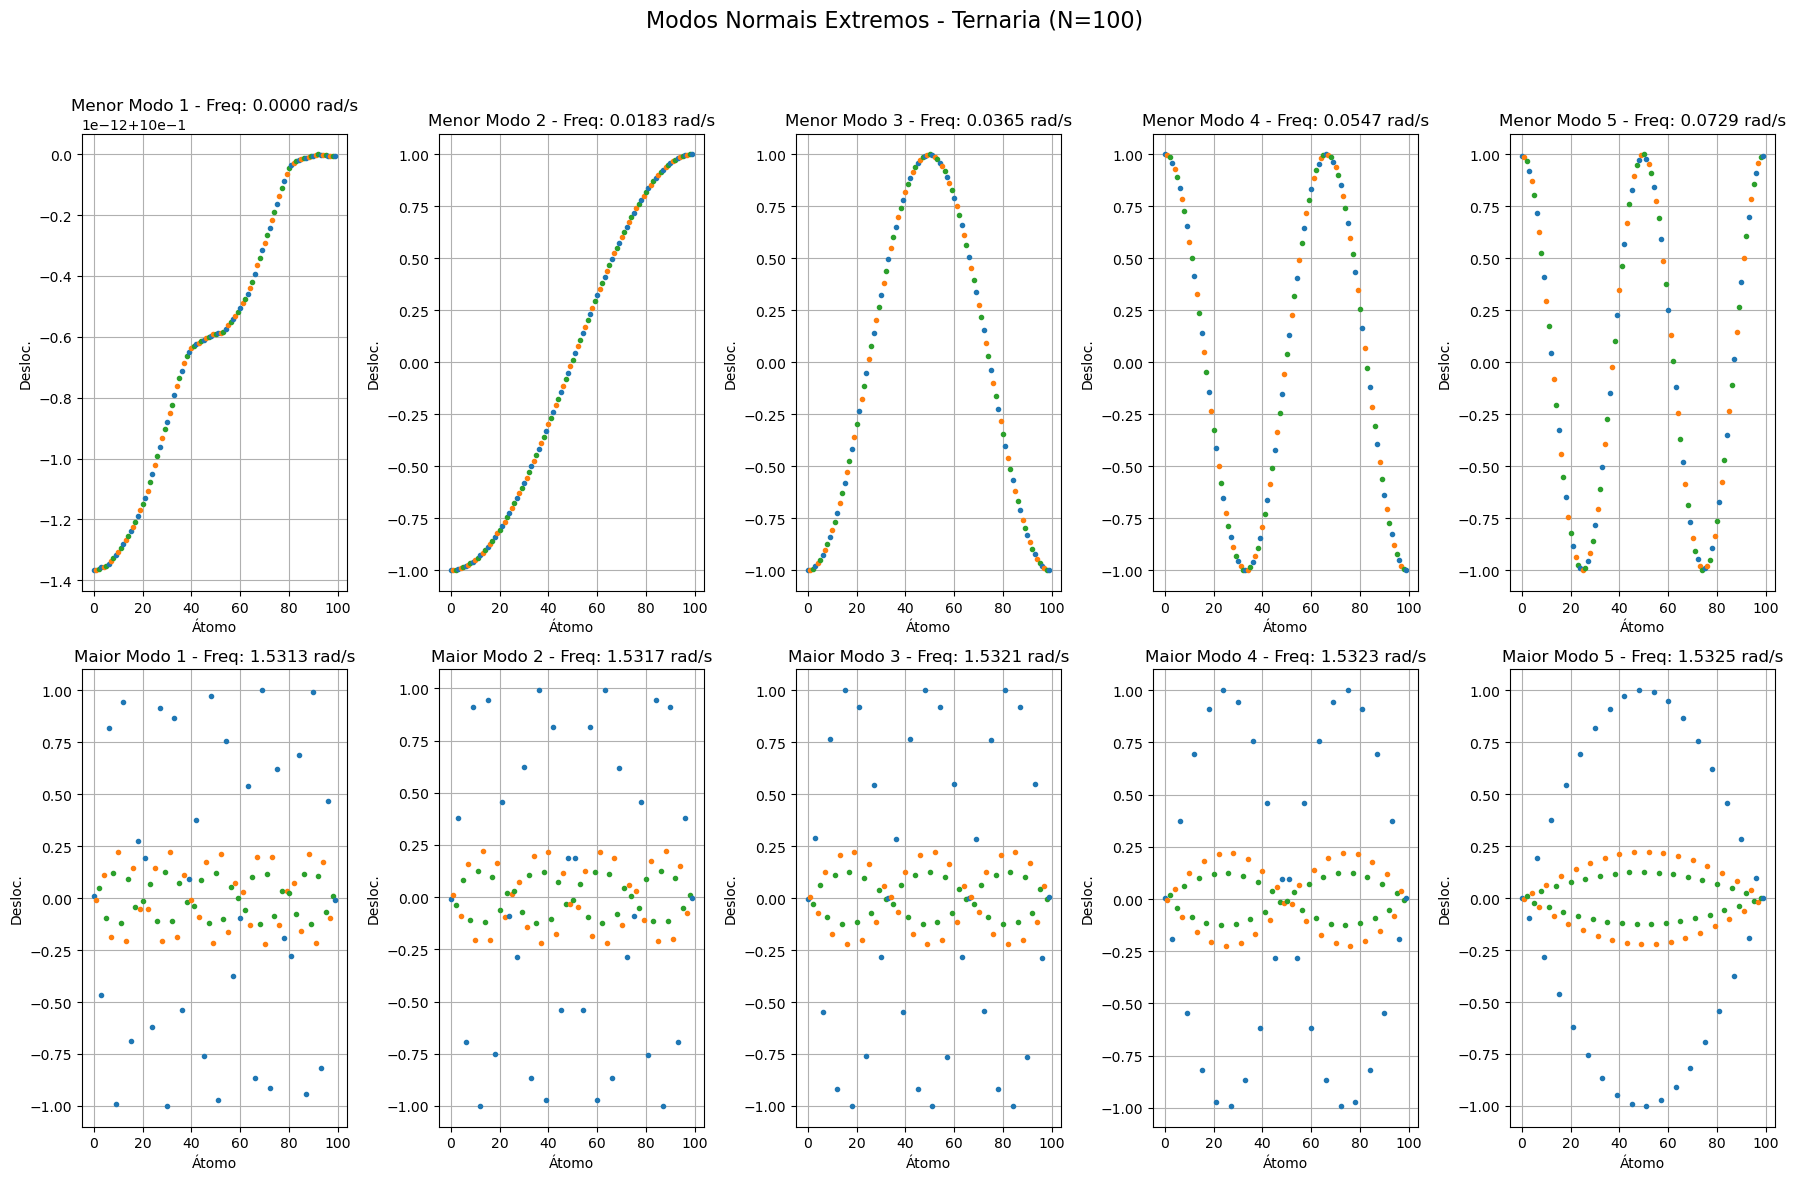


===== N = 1000 =====


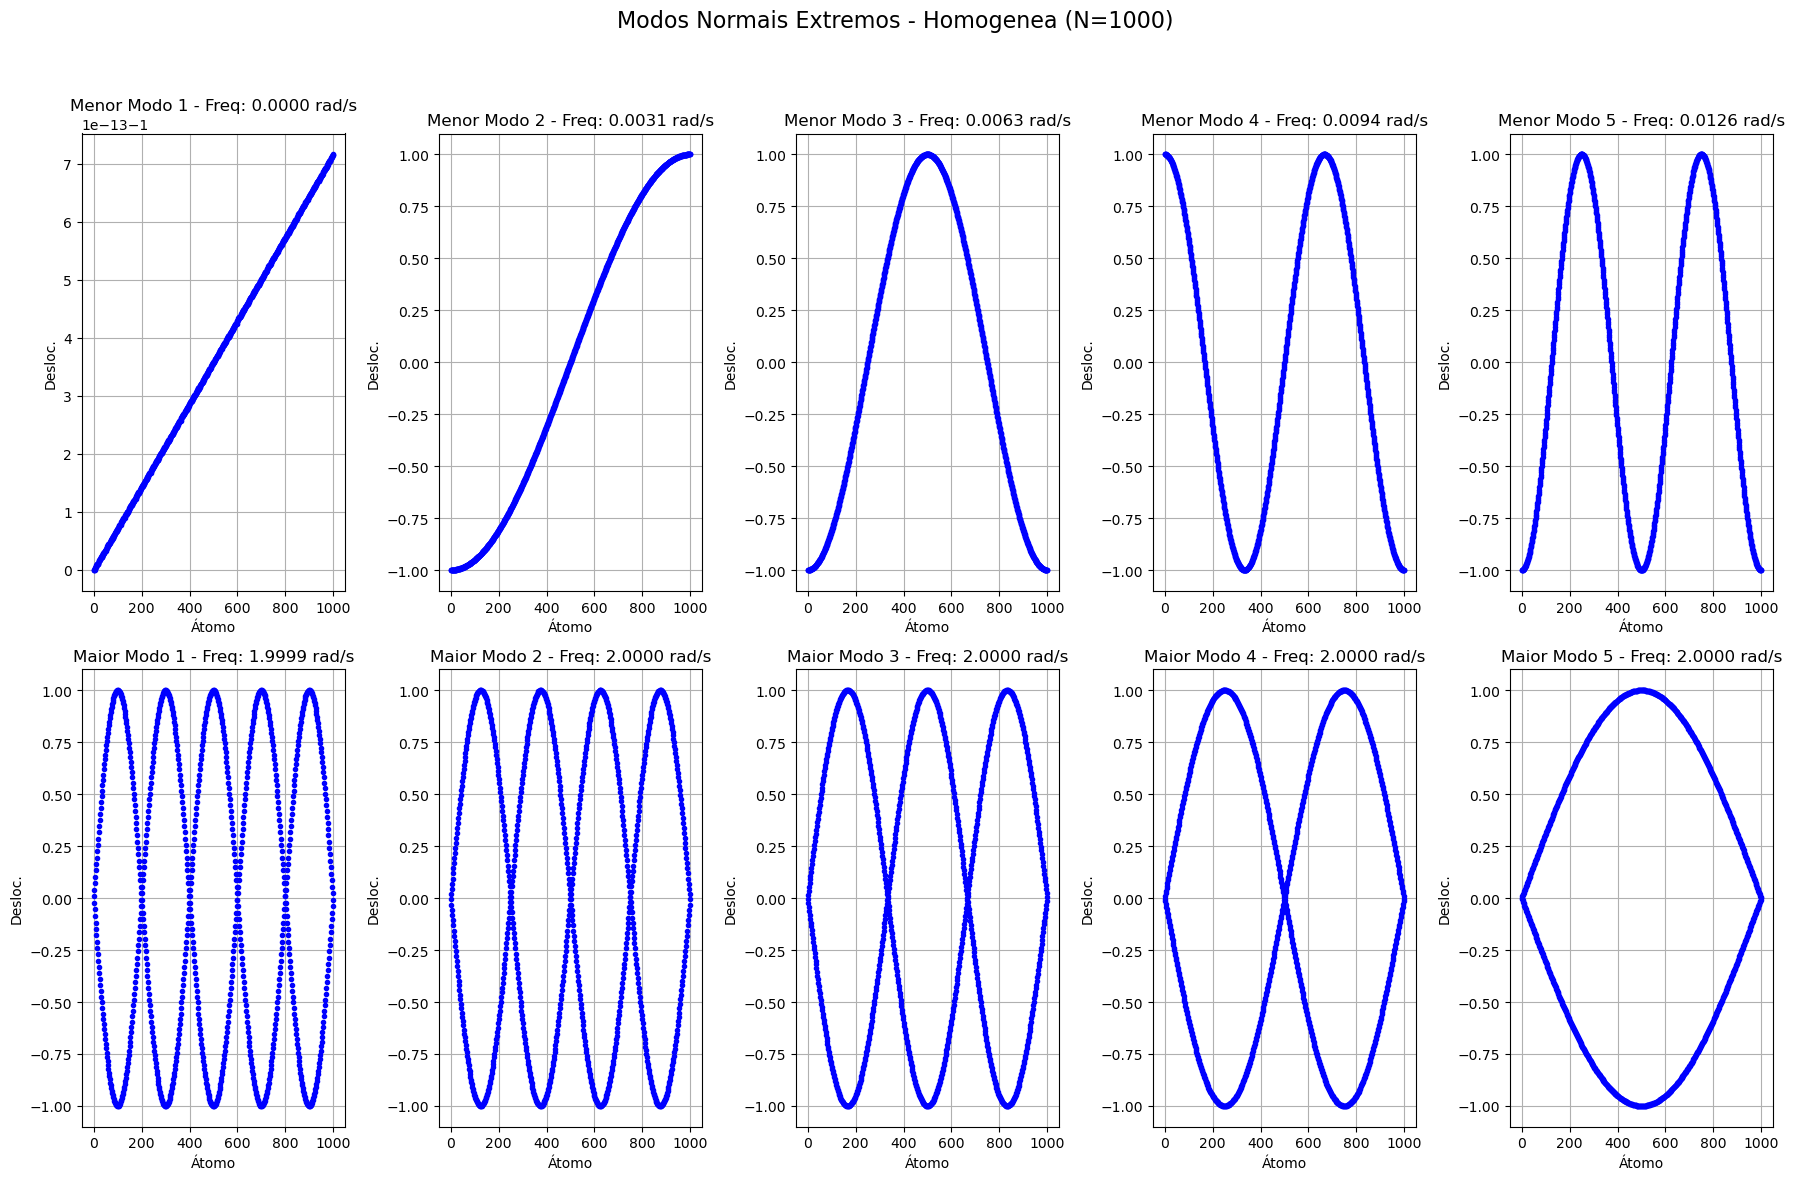

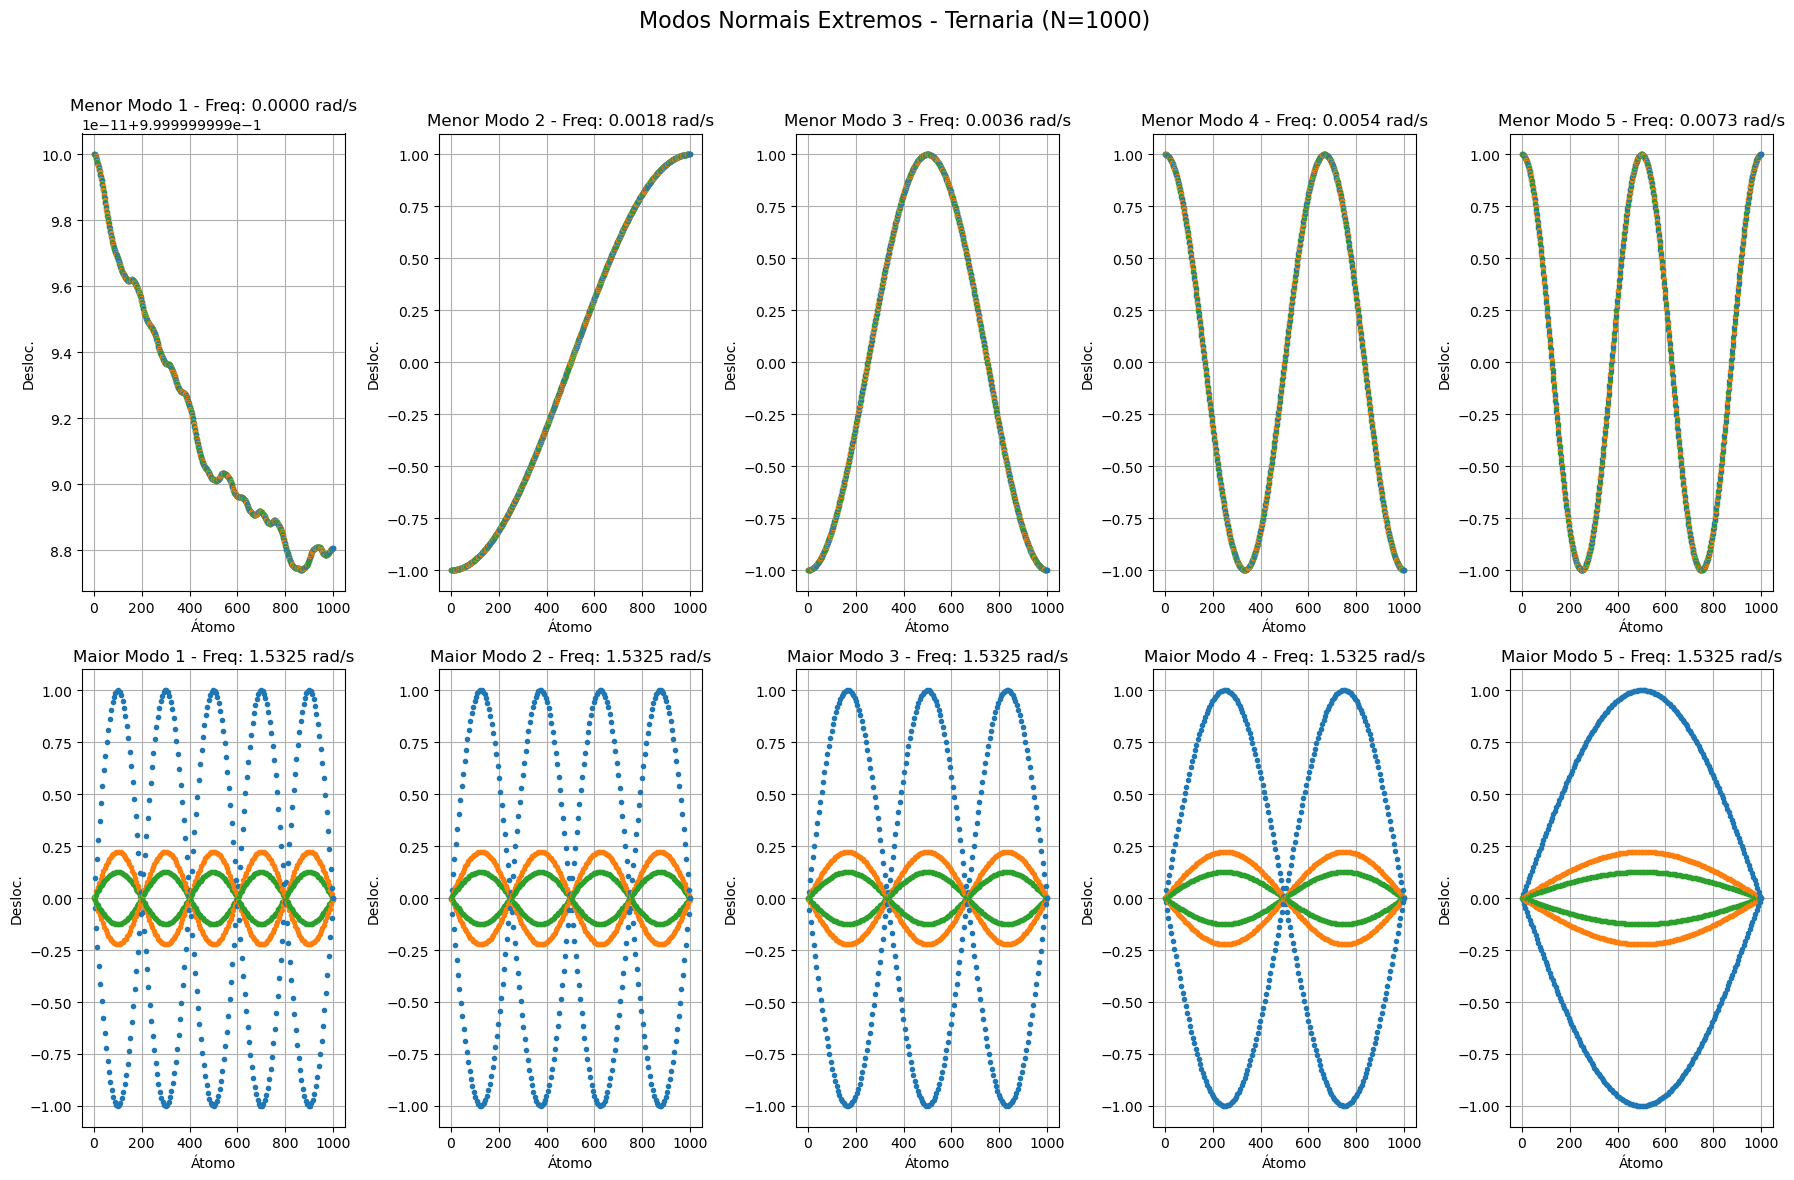

In [20]:
def plotar_modos_extremos(modos, freq, N, tipo, n_modos=5, massas=None):
    plt.figure(figsize=(18, 12))

    # Índices das 5 menores e 5 maiores frequências
    indices_menores = np.argsort(freq)[:n_modos]
    indices_maiores = np.argsort(freq)[-n_modos:]

    # Definir cores para as massas (apenas para a cadeia ternária)
    cores = None
    if tipo == 'ternaria' and massas is not None:
        unique_massas = np.unique(massas)
        cores = {massa: plt.cm.tab10(i) for i, massa in enumerate(unique_massas)}

    # Plot dos modos de menor frequência
    for i, idx in enumerate(indices_menores):
        desloc = modos[:, idx]
        desloc /= np.max(np.abs(desloc))  # normaliza
        plt.subplot(2, n_modos, i + 1)
        for j, desloc_j in enumerate(desloc):
            cor = cores[massas[j]] if cores else 'b'  # Cor por massa ou padrão
            plt.plot(j, desloc_j, marker='.', color=cor)
        plt.title(f"Menor Modo {i+1} - Freq: {freq[idx]:.4f} rad/s")
        plt.xlabel("Átomo")
        plt.ylabel("Desloc.")
        plt.grid(True)

    # Plot dos modos de maior frequência
    for i, idx in enumerate(indices_maiores):
        desloc = modos[:, idx]
        desloc /= np.max(np.abs(desloc))  # normaliza
        plt.subplot(2, n_modos, n_modos + i + 1)
        for j, desloc_j in enumerate(desloc):
            cor = cores[massas[j]] if cores else 'b'  # Cor por massa ou padrão
            plt.plot(j, desloc_j, marker='.', color=cor)
        plt.title(f"Maior Modo {i+1} - Freq: {freq[idx]:.4f} rad/s")
        plt.xlabel("Átomo")
        plt.ylabel("Desloc.")
        plt.grid(True)

    plt.suptitle(f"Modos Normais Extremos - {tipo.capitalize()} (N={N})", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Execução para os Ns desejados
Ns = [100, 1000]

for N in Ns:
    print(f"\n===== N = {N} =====")

    # Homogênea
    sistema_hom = CadeiaAtomica(N=N, tipo='homogenea')
    freq_hom, modos_hom = sistema_hom.calcular_frequencias_e_modos()
    plotar_modos_extremos(modos_hom, freq_hom, N, tipo='homogenea')

    # Ternária
    sistema_tern = CadeiaAtomica(N=N, tipo='ternaria')
    freq_tern, modos_tern = sistema_tern.calcular_frequencias_e_modos()
    massas_tern = sistema_tern.massas  # Supondo que o sistema ternário tenha um atributo 'massas'
    plotar_modos_extremos(modos_tern, freq_tern, N, tipo='ternaria', massas=massas_tern)

### Exercício 04
![alt text](ex4.png)

#### Análise e Comparação

> #### Distribuição das Frequências (Densidade de Estados)

**Cadeia Homogênea:**
- Apresenta uma distribuição de frequências contínua e suave.
- A forma da curva de densidade de estados é típica de sistemas com simetria translacional uniforme.
- As frequências estão densamente distribuídas dentro de uma única banda contínua.

**Cadeia Ternária:**
- A distribuição das frequências apresenta **lacunas (band gaps)** visíveis entre grupos de frequências.
- Essas bandas surgem devido à alternância de massas, que quebra a simetria simples do sistema.
- A densidade de estados é composta por múltiplas faixas separadas, o que caracteriza o surgimento de zonas proibidas de vibração.

**Conclusão:**  A alternância de massas na cadeia ternária introduz **band gaps** na densidade de estados — algo que **não ocorre** na cadeia homogênea. Esse comportamento é análogo à formação de bandas proibidas em sólidos cristalinos com múltiplos átomos por célula unitária.


> #### Padrões de Deslocamento dos Modos Normais

**Modos de Baixa Frequência (baixa energia):**
- Em ambas as cadeias, os modos de baixa frequência apresentam **movimentos coletivos** e suaves, com muitos átomos vibrando em fase.
- Esses modos se assemelham a ondas acústicas de baixa energia.

**Modos de Alta Frequência (alta energia):**
- Na cadeia homogênea, os modos de alta frequência são contínuos, com rápida oscilação dos átomos ao longo da cadeia.
- Na cadeia ternária, os modos de alta frequência apresentam **localização espacial**: certos átomos vibram com amplitude maior, enquanto outros permanecem quase imóveis.

**Localização dos Modos:**
- A estrutura ternária favorece a **localização vibracional** em regiões específicas da cadeia, especialmente nas massas mais leves.
- A heterogeneidade introduzida pelas diferentes massas impede o espalhamento uniforme da energia vibracional.

**Conclusão:**   A cadeia homogênea apresenta modos normais mais distribuídos e contínuos, enquanto a cadeia ternária exibe **modos localizados**, especialmente nos de alta frequência, devido à diferença de inércia entre as massas \( m,\ 3m,\ 5m \).

> #### Lacunas de Frequência (Band Gaps)

**Cadeia Homogênea:**
- Não há lacunas de frequência. As frequências cobrem uma faixa contínua desde zero até uma frequência máxima.

**Cadeia Ternária:**
- Apresenta lacunas de frequência visíveis entre bandas de modos vibracionais.
- Essas **band gaps** são resultado direto da estrutura periódica com múltiplas massas diferentes, o que cria zonas proibidas de propagação de certos modos.

**Conclusão:**   A cadeia ternária apresenta **band gaps claramente identificáveis**, que se tornam mais evidentes à medida que \( N \) aumenta. Esses fenômenos são importantes na modelagem de cristais, isolantes e dispositivos fonônicos.

#### Resumo Comparativo

| Característica                    | Cadeia Homogênea              | Cadeia Ternária                      |
|----------------------------------|-------------------------------|--------------------------------------|
| Distribuição das Frequências     | Contínua e suave              | Em bandas, com lacunas (band gaps)   |
| Modos de Baixa Frequência        | Ondas coletivas suaves        | Ondas suaves com perturbações leves  |
| Modos de Alta Frequência         | Oscilações rápidas contínuas  | Modos **localizados** por inércia    |
| Lacunas de Frequência            | Não existem                   | Sim, existem lacunas visíveis        |
| Localização Vibracional          | Pouco ou nenhum               | Presente nos modos de alta energia   |